In [1]:
#Imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
#Network parameters
batch_size = 64
img_height = 224
img_width = 224

In [59]:
test_folder = '../images/uk_us/train'
preprocessor = keras.applications.resnet50.preprocess_input
test_data_generator = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocessor)
test_set = test_data_generator.flow_from_directory(test_folder, class_mode='binary',target_size=(img_height,img_width))

Found 60000 images belonging to 2 classes.


In [60]:
#Get pretrained model
resnet_model = tf.keras.applications.ResNet50(input_shape=(img_width, img_height, 3), include_top=False, pooling='avg', weights='imagenet')
resnet_model.trainable = False
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [61]:
#add classfier
model = keras.models.Sequential([resnet_model, keras.layers.Dense(1, name='logits', activation='sigmoid')])

In [62]:
#model.load_weights('./model_checkpoints/uk_not_uk/location_classifier') #uk/notuk
model.load_weights('./model_checkpoints/uk_us/new_location_classifier') #uk/us

In [63]:
def get_original_image(x):
    x += 1
    x *= 127.5
    x /= 255.
    x = x[..., ::-1]
    x = np.interp(x, (x.min(), x.max()), (0, 1))
    return x

In [64]:
images, labels = test_set.next()

In [65]:
sample_imgs = []
for i in range(2):
    valid = images[labels == i]
    pick = np.random.choice(range(len(valid)), 5, replace=False)
    for j in pick:
        sample_imgs.append(valid[j])

sample_imgs = np.array(sample_imgs)

In [66]:
hmaps = []
for i, sample_image in enumerate(sample_imgs):
    with tf.GradientTape() as g:
        sample_img = tf.convert_to_tensor(sample_image, dtype=tf.float32)
        g.watch(sample_img)
        logits = model(sample_img[np.newaxis,...])
        SA_scores = tf.square(g.gradient(logits, sample_img)) #convert to binary cross entropy
        hmaps.append(SA_scores)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

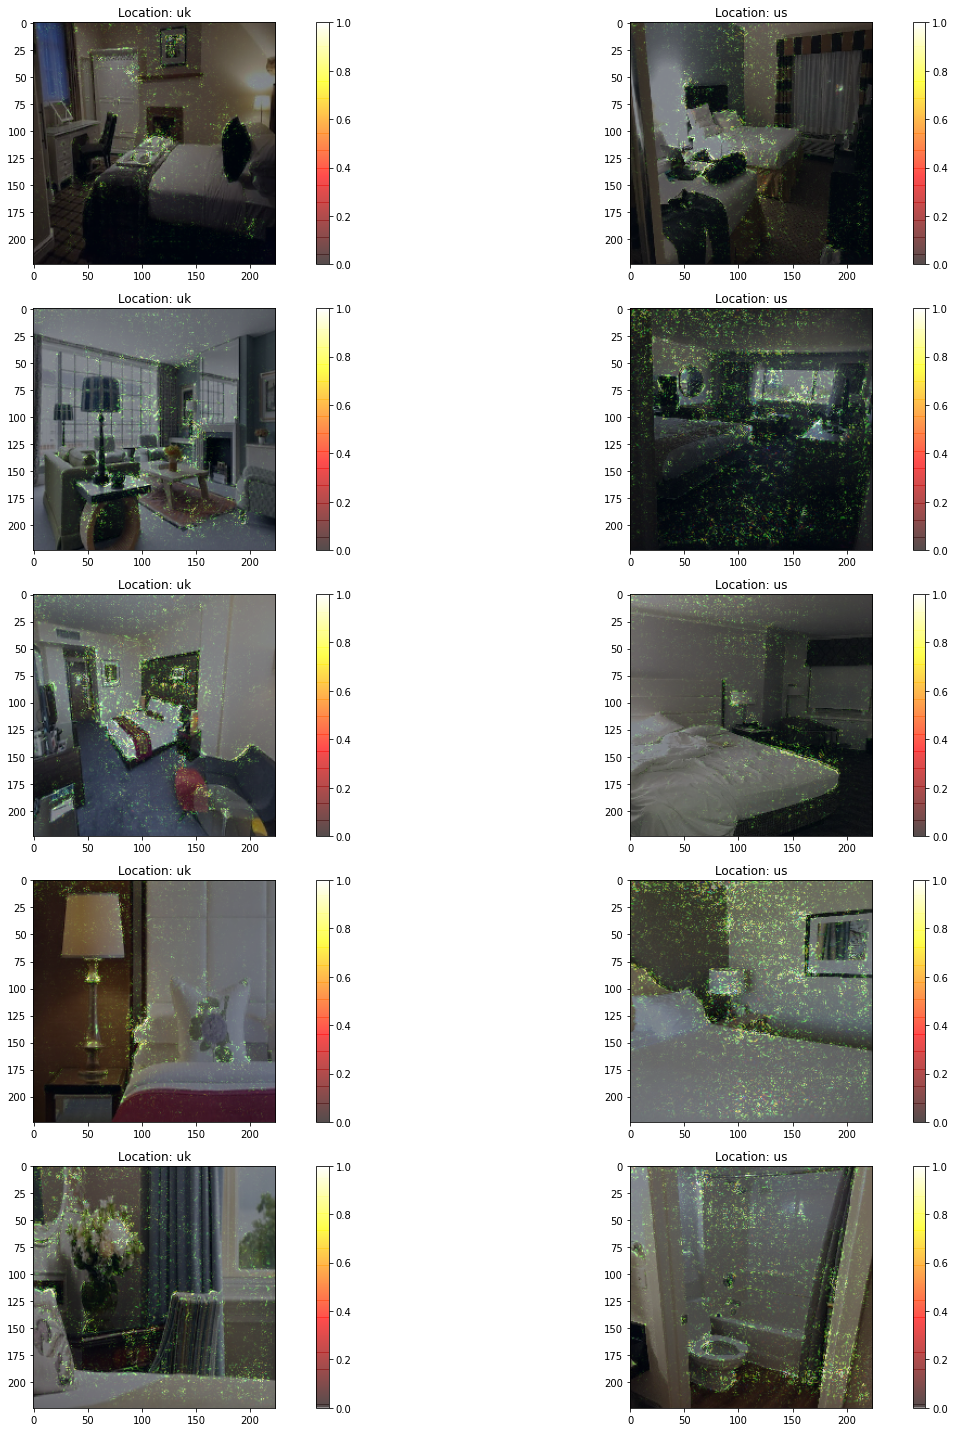

In [67]:
classes = ['uk', 'us']
fig = plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(get_original_image(sample_imgs[i]))
    h = hmaps[i].numpy()
    heat_map = np.interp(h[:,:,::-1], (h.min(), h.max()), (0, 20))
    plt.imshow(np.reshape(heat_map, [224,224,3]), cmap='hot', alpha=0.45)
    plt.title(f'Location: {classes[0]}')
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(get_original_image(sample_imgs[5+i]))
    h = hmaps[5 + i].numpy()
    heat_map = np.interp(h[:,:,::-1], (h.min(), h.max()), (0, 20))
    plt.imshow(np.reshape(heat_map, [224,224,3]), cmap='hot', alpha=0.45)
    plt.title(f'Location: {classes[1]}')
    plt.colorbar()

plt.tight_layout()

In [54]:
fig.savefig("plot_test_ukus.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


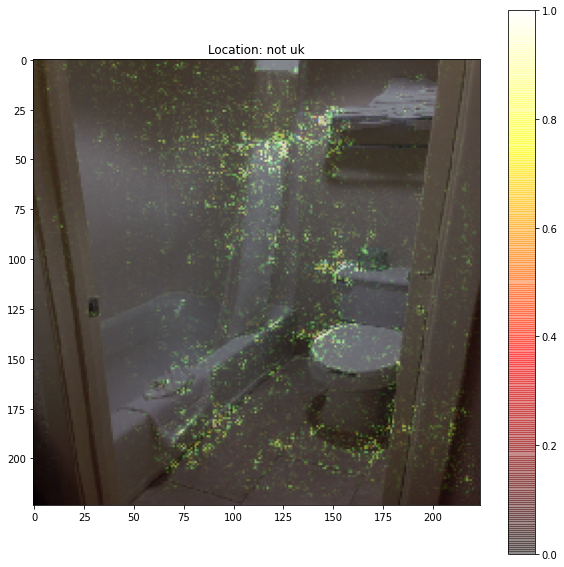

In [18]:
classes = ['uk', 'us']
plt.figure(figsize=(10,10))
#Show NOT UK first

plt.imshow(get_original_image(sample_imgs[0]))
h0 = hmaps[0].numpy()
heat_map0 = np.interp(h0[:,:,::-1], (h0.min(), h0.max()), (0, 20))
plt.imshow(np.reshape(heat_map0, [224,224,3]), cmap='hot', alpha=0.45)
plt.title(f'Location: {classes[0]}')
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


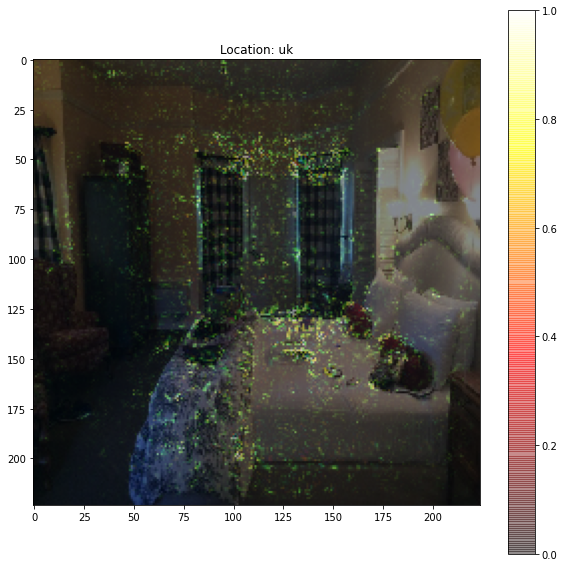

In [96]:
#Show UK 
plt.figure(figsize=(10,10))
plt.imshow(get_original_image(sample_imgs[1]))
h1 = hmaps[1].numpy()
heat_map1 = np.interp(h1[:,:,::-1], (h1.min(), h1.max()), (0, 10))
plt.imshow(np.reshape(heat_map1, [224,224,3]), cmap='hot', alpha=0.45)
plt.title(f'Location: {classes[1]}')
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


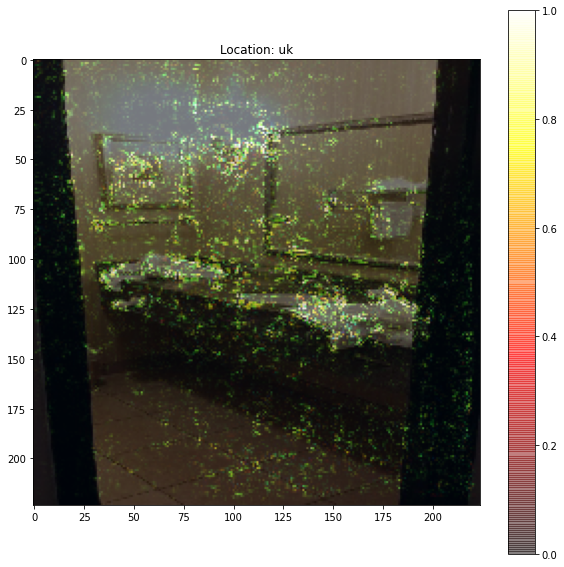

In [28]:
#Show UK 
plt.figure(figsize=(10,10))
h1 = hmaps[1].numpy()
im1 = (sample_imgs[1])[:,:,::-1]
heat_map1 = np.interp(h1, (h1.min(), h1.max()), (0, 15))
img_1 = np.interp(im1, (im1.min(), im1.max()), (0, 1))
plt.imshow(img_1, cmap='gray')
plt.imshow(np.reshape(heat_map1[:,:,::-1], [224,224,3]), cmap='hot', alpha=0.5)
plt.title(f'Location: {classes[1]}')
plt.colorbar()

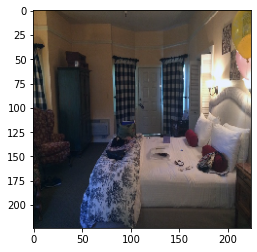

In [94]:
ximg = get_original_image(sample_imgs[1])
plt.imshow(ximg)